### Libraries

#### install libraries

In [74]:
pip install datasets

In [75]:
pip install torchmetrics

#### import libraries

In [76]:
#basic 

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from datasets import load_dataset,Dataset, concatenate_datasets

from collections import Counter
from PIL import Image


# ml & dl

import torch
import torchvision.transforms as tv
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

### Data Analysis

#### Data Loading

In [3]:
ds = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [4]:
print(ds)

# master label
# 0 cardboard
# 1 glass
# 2 metal
# 3 paper
# 4 plastic

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


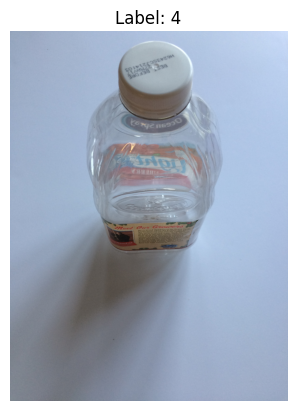

In [6]:
sample_img = ds['train'][2005]['image']
sample_label = ds['train'][2005]['label']

plt.imshow(sample_img)
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

#### Data Validation

-> optional to run

In [12]:
labels = [data['label'] for data in ds['train']]

In [13]:
label_count = Counter(labels)
print(label_count)

Counter({3: 1188, 1: 1002, 4: 964, 2: 820, 0: 806, 5: 274})


In [14]:
def validate_img(ds):
    count=0
    for i in ds['train']:
        try:
            img = i['image'] #load image to check
            count+=1
        except Exception as e:
            print(f"total number of corrupt images:{e}")
    print(f"total number of valid iamges:{count}")


validate_img(ds)
# o/p
# total number of valid iamges:5054

total number of valid iamges:5054


#### Data Splitting


In [7]:
split_ds = ds["train"].train_test_split(test_size = 0.2, seed=42 )
temp = split_ds["test"].train_test_split(test_size = 0.5, seed=42 )

split_ds = {
    "train" : split_ds["train"],
    "validation" : temp["train"],
    "test" : temp["test"]
}

print('train size',len(split_ds['train']))
print('validation size', len(split_ds['validation']))
print('test size', len(split_ds['test']))


train size 4043
validation size 505
test size 506


#### Image Analysis

In [8]:
def resize_img(placeholder, size=(244, 244)):
    img = placeholder['image']
    if isinstance(img, Image.Image):  
        placeholder['image'] = img.resize(size)
    return placeholder


In [9]:
split_ds['train'] = split_ds['train'].map(lambda x: resize_img(x, size=(244, 244)))
split_ds['validation'] = split_ds['validation'].map(lambda x: resize_img(x, size=(244, 244)))
split_ds['test'] = split_ds['test'].map(lambda x: resize_img(x, size=(244, 244)))


# 21mins

Map:   0%|          | 0/4043 [00:00<?, ? examples/s]

Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Map:   0%|          | 0/506 [00:00<?, ? examples/s]

In [10]:
print(split_ds["train"])
print(split_ds["validation"])
print(split_ds["test"])

Dataset({
    features: ['image', 'label'],
    num_rows: 4043
})
Dataset({
    features: ['image', 'label'],
    num_rows: 505
})
Dataset({
    features: ['image', 'label'],
    num_rows: 506
})


image verification

In [11]:
# Function to print the size of images
def check_image_sizes(dataset, num_samples=5):
    for i in range(num_samples):
        image = dataset[i]['image']
        print(f"Image {i+1}: Size = {image.size}")

# Verify image sizes for train, validation, and test splits
print("Train Dataset:")
check_image_sizes(split_ds['train'])

print("\nValidation Dataset:")
check_image_sizes(split_ds['validation'])

print("\nTest Dataset:")
check_image_sizes(split_ds['test'])

Train Dataset:
Image 1: Size = (244, 244)
Image 2: Size = (244, 244)
Image 3: Size = (244, 244)
Image 4: Size = (244, 244)
Image 5: Size = (244, 244)

Validation Dataset:
Image 1: Size = (244, 244)
Image 2: Size = (244, 244)
Image 3: Size = (244, 244)
Image 4: Size = (244, 244)
Image 5: Size = (244, 244)

Test Dataset:
Image 1: Size = (244, 244)
Image 2: Size = (244, 244)
Image 3: Size = (244, 244)
Image 4: Size = (244, 244)
Image 5: Size = (244, 244)


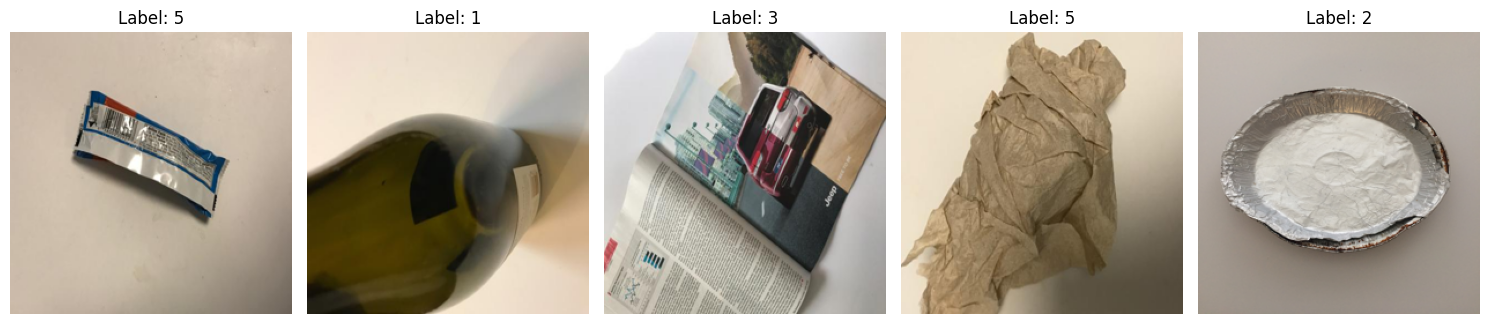

In [14]:
n= 5  # Number of images to display
random_indices = random.sample(range(len(split_ds['train'])), n)  # Random indices

fig, axes = plt.subplots(1, n, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image = split_ds['train'][idx]['image']  
    label = split_ds['train'][idx]['label']  
    
    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Data Augmentation

In [57]:
data_transform = tv.Compose([
    tv.RandomHorizontalFlip(p=0.5),
    tv.RandomRotation(degrees=15),
    tv.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    tv.ToTensor(),
    tv.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
])

In [58]:
def augment_image(example):
    image = example['image']
    if isinstance(image, Image.Image):
        # Print shape and value range before transform
        print("Original image size:", image.size)
        image = data_transform(image)
        # Print tensor info after transform
        print("Tensor shape:", image.shape)
        print("Tensor value range:", torch.min(image).item(), torch.max(image).item())
        example['image'] = image
    return example

In [59]:
augmented_subset = split_ds['train'].select(range(10)).map(augment_image)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -1.0 1.0
Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -1.0 1.0
Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -1.0 0.6235294342041016
Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -1.0 0.7411764860153198
Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -1.0 1.0
Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -1.0 1.0
Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -0.8509804010391235 1.0
Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -1.0 1.0
Original image size: (244, 244)
Tensor shape: torch.Size([3, 244, 244])
Tensor value range: -1.0 1.0
Original image size: (244, 244)
Tensor shape: 

In [60]:
def display_augmented_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        augmented_image = dataset[i]['image']
        
        if torch.is_tensor(augmented_image):
            augmented_image = to_pil_image(augmented_image)
        elif isinstance(augmented_image, list):
            if len(augmented_image) > 0:
                img = augmented_image[0]
                if torch.is_tensor(img):
                    augmented_image = to_pil_image(img)
                else:
                    augmented_image = img
        
        axes[i].imshow(augmented_image)
        axes[i].set_title(f"Augmented Image {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [61]:
def display_original_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        original_image = dataset[i]['image']
        if isinstance(original_image, Image.Image):
            axes[i].imshow(original_image)
            axes[i].set_title(f"Original Image {i+1}")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

Original images:


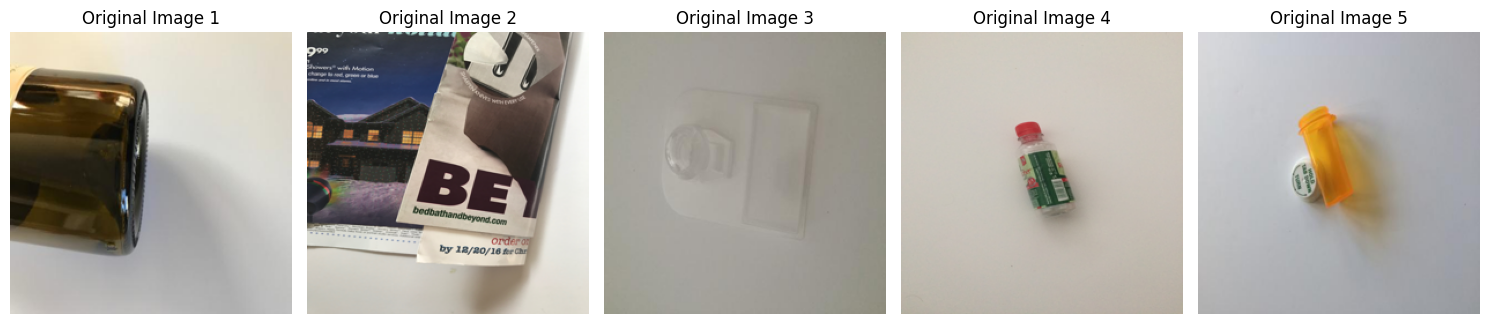


Augmented images:


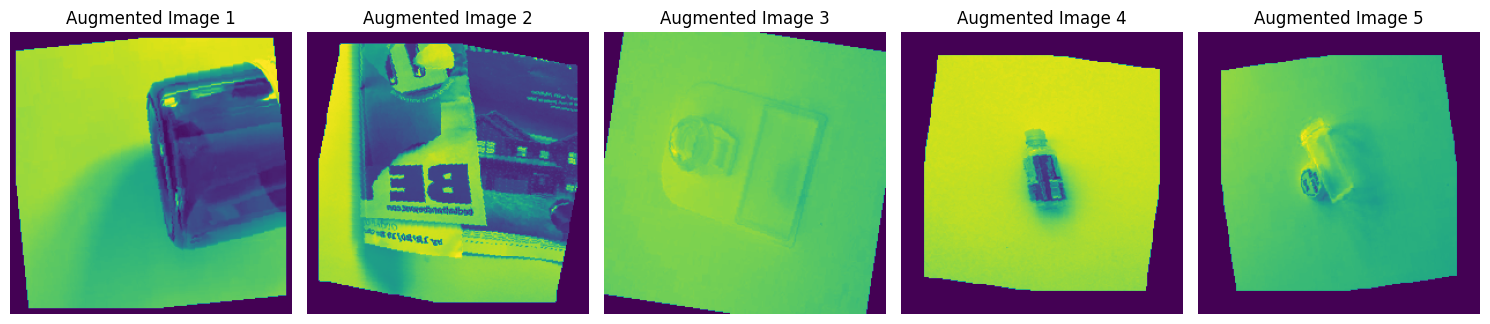

In [62]:
print("Original images:")
display_original_images(split_ds['train'].select(range(10)))

print("\nAugmented images:")
display_augmented_images(augmented_subset)

### Training & Testing

#### wandb setup

In [69]:
pip install wandb

In [70]:
import wandb

In [79]:
wandb.login()

True

In [82]:
print(wandb.api.default_entity)

indomie


In [86]:
wandb.init(
    project="trash-classification",
    entity="solo-only", 
    config={
        "learning_rate": 0.001,
        "epochs": 5,
        "batch_size": 32,
        "architecture": "TrashNet"
    },
    settings=wandb.Settings(init_timeout=300) 
)

#### Model Development

In [89]:
class TrashNet(nn.Module):
    def __init__(self, num_classes=6):
        super(TrashNet, self).__init__()
        self.features = nn.Sequential(
            # First Conv Block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Second Conv Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Third Conv Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Fourth Conv Block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 15 * 15, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Dload images
class TrashDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [90]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Function to plot training history
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [91]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    save_dir = "checkpoints"
    os.makedirs(save_dir, exist_ok=True)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Step the scheduler
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path) 
        wandb.save(checkpoint_path)  
        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")
    
        # Save model after each epoch
        torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
        wandb.save(f"model_epoch_{epoch+1}.pth")
    
    return train_losses, val_losses, train_accs, val_accs

In [92]:
# evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    accuracy = Accuracy(task="multiclass", num_classes=6).to(device)
    precision = Precision(task="multiclass", num_classes=6).to(device)
    recall = Recall(task="multiclass", num_classes=6).to(device)
    f1 = F1Score(task="multiclass", num_classes=6).to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.append(predicted)
            all_labels.append(labels)
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    acc = accuracy(all_preds, all_labels)
    prec = precision(all_preds, all_labels)
    rec = recall(all_preds, all_labels)
    f1_score = f1(all_preds, all_labels)
    
    return {
        'accuracy': acc.item(),
        'precision': prec.item(),
        'recall': rec.item(),
        'f1_score': f1_score.item()
    }

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# datasets
train_dataset = TrashDataset(split_ds['train'], transform=data_transform)
val_dataset = TrashDataset(split_ds['validation'], transform=data_transform)
test_dataset = TrashDataset(split_ds['test'], transform=data_transform)

# data loaders 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model
model = TrashNet(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

num_epochs = 5
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)

Epoch 1/5:
Train Loss: 4.3076, Train Acc: 32.15%
Val Loss: 1.4228, Val Acc: 40.00%

Epoch 2/5:
Train Loss: 1.5176, Train Acc: 39.10%
Val Loss: 1.4070, Val Acc: 43.17%

Epoch 3/5:
Train Loss: 1.4849, Train Acc: 40.27%
Val Loss: 1.4129, Val Acc: 47.52%

Epoch 4/5:
Train Loss: 1.4567, Train Acc: 40.69%
Val Loss: 1.3362, Val Acc: 47.13%

Epoch 5/5:
Train Loss: 1.4425, Train Acc: 41.78%
Val Loss: 1.3314, Val Acc: 50.89%



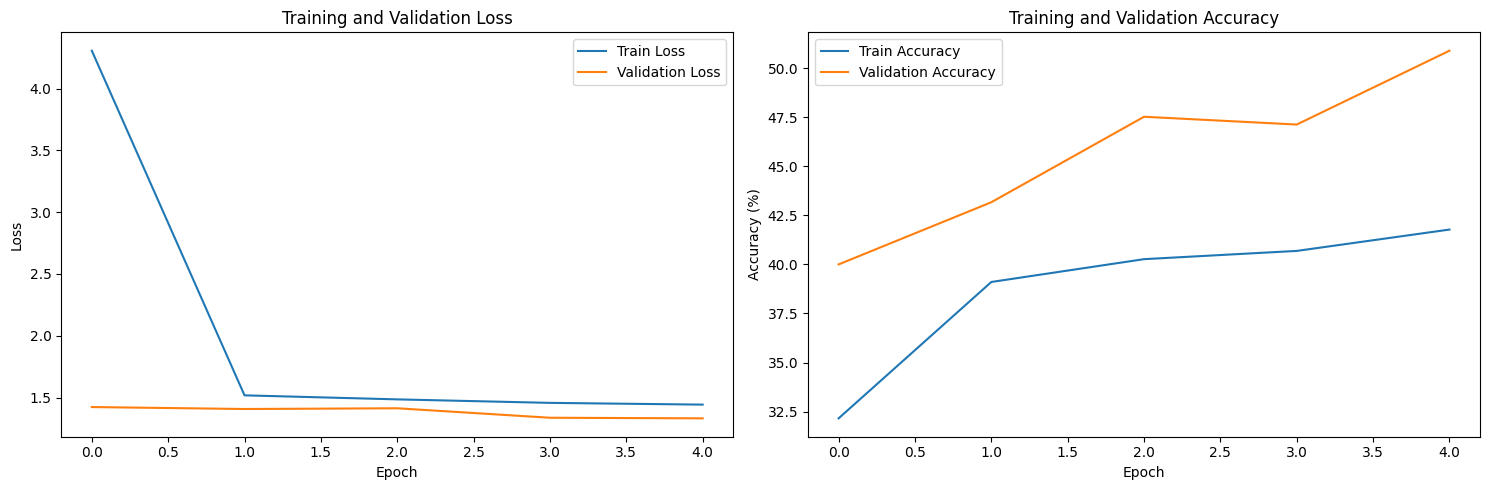

<Figure size 640x480 with 0 Axes>

In [95]:
# Plot training history
plot_training_history(*history)

#log progress
wandb.log({"Training History": wandb.Image(plt)})

In [96]:
# Evaluate on test set
test_metrics = evaluate_model(model, test_loader, device)
print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# log progress
wandb.log(test_metrics)


Test Set Metrics:
accuracy: 0.4862
precision: 0.4862
recall: 0.4862
f1_score: 0.4862


In [97]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [99]:
wandb offline

SyntaxError: invalid syntax (<ipython-input-99-0656e0589a81>, line 1)